# Phase 2 Group 1 Project

## Overview

Acme Bank

XXX

## Business Problem

XXXX

## Data Understanding

XXXX

## Import

Here we imported all the relevant libraries for the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import OLSInfluence as influence

## Review the Data File

The data file was reviewed to get a better understanding of what features were included and what data types are the features

In [2]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

After reviewing the data, we noticed that some of the columns had nulls or the wrong data type. For the nulls, we made assumptions to fill in the null values. The column "sqft_basement" had to be converted to a number.

In [5]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [6]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [7]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [8]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [9]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

We also extracted the month from the date to see if there were any seasonal impact on housing prices.

In [10]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

We converted the year built column to the age of the house to compare the data more easily

In [11]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [12]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [13]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [14]:
#reset index
df.reset_index(inplace=True, drop=True)

In [15]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [16]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


## Exploratory Data Analysis (EDA)

In the EDA phase, we explored the target and the features included in the data. For this project, 'price' will be our target, and the remaining data will be our features. 

### Target: Price

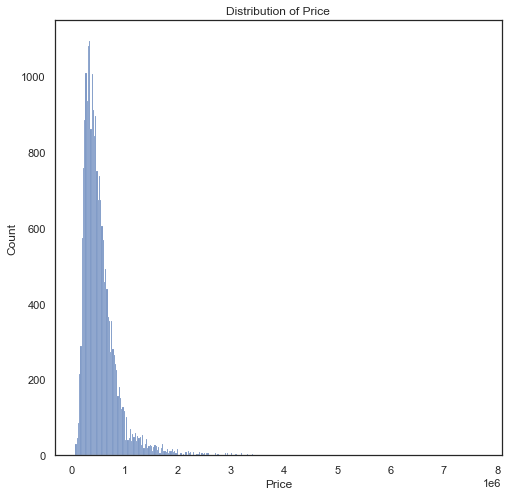

In [18]:
#Since price is our target, we will explore first
#view distribution of price using histogram
sns.set(style = 'white')
fig, ax = plt.subplots(figsize = (8,8))
sns.histplot(data = df, x = 'price', palette = 'Dark', )
ax.set_xlabel('Price')
ax.set_ylabel('Count')
ax.set_title('Distribution of Price')
plt.show()

We notice from the histogram that the price data is skewed to the right, indicating a non-normal distribution. This is further validated by the box-plot below

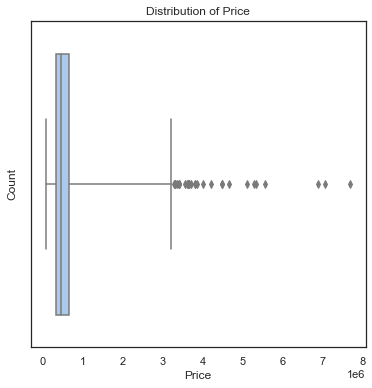

In [19]:
#plot a boxplot for price
sns.set(style = 'white')
fig, ax = plt.subplots(figsize = (6,6))
sns.boxplot(data = df, x = 'price', palette = 'pastel', fliersize = 5, whis = 8)
ax.set_xlabel('Price')
ax.set_ylabel('Count')
ax.set_title('Distribution of Price')
plt.show()

To normalize the price data, we log-transformed (base of e) the data. We can see in the histogram below, the log-transformed data looks more similar to a normal distribution than untransformed price data. 

In [20]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

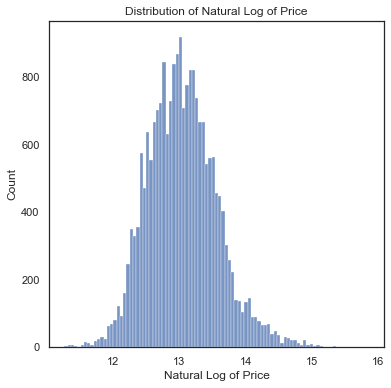

In [21]:
#view distribution of log base e for price using histogram
sns.set(style = 'white')
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(data = df, x = 'ln_price', palette = 'Dark')
ax.set_xlabel('Natural Log of Price')
ax.set_ylabel('Count')
ax.set_title('Distribution of Natural Log of Price')
plt.show()

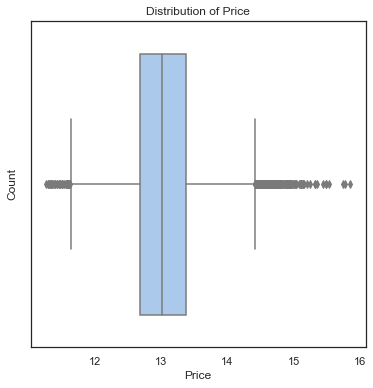

In [22]:
sns.set(style = 'white')
fig, ax = plt.subplots(figsize = (6,6))
sns.boxplot(data = df, x = 'ln_price', palette = "pastel")
ax.set_xlabel("Price")
ax.set_ylabel("Count")
ax.set_title("Distribution of Price")
plt.show()

### Features: Everything Else

To review the features of the data, we first analyze a pair plot of the data to first identify the numeric and categorical features. We can also see linearity between the target and each feature from the plot. 

In [23]:
#plot the pairplot of the dataframe
#note that both price and ln(price) are included
#sns.pairplot(df)

In [24]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [25]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

It's important to validate that all observations are properly input or they could throw off the modeling process. Some erroneous observations may have values that dont make sense in a realworld context making them easy to identify and remove. 

In [26]:
#visually inspecting value counts to look for weird values
for column in df.columns:
    if not column == 'price':
        display(df[column].value_counts())

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

0    21451
1      146
Name: waterfront, dtype: int64

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

0    20853
1      744
Name: if_renovated, dtype: int64

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

47.6624    17
47.5491    17
47.5322    17
47.6846    17
47.6711    16
           ..
47.2785     1
47.4162     1
47.3870     1
47.2313     1
47.2715     1
Name: lat, Length: 5033, dtype: int64

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
           ... 
-121.403      1
-121.804      1
-121.726      1
-121.895      1
-121.893      1
Name: long, Length: 751, dtype: int64

1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_of_date, dtype: int64

 9      472
 8      443
 11     431
 0      430
 10     428
       ... 
 113     28
 115     26
 81      23
 80      21
-1       12
Name: age_of_house, Length: 117, dtype: int64

13.017003    172
12.765688    172
13.217674    159
13.122363    152
12.959844    150
            ... 
12.939128      1
12.857382      1
12.341041      1
13.109278      1
12.457609      1
Name: ln_price, Length: 3622, dtype: int64

In [27]:
#found 1 obs that should be removed
df[df['bedrooms'] >= 20]
df.drop(15856, inplace=True)

In [28]:
#these look fine
df[df['bathrooms']>6]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house,ln_price
4020,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,...,2400,0,98166,47.4643,-122.368,2810,33190,10,61,13.592367
7245,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,...,3480,1,98102,47.6298,-122.323,3940,8800,10,104,15.856731
8085,4670000.0,5,6.75,9640,13068,1.0,1,4,3,12,...,4820,1,98040,47.5570,-122.210,3270,10454,6,31,15.356670
8537,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,...,0,0,98144,47.5923,-122.301,1448,3866,8,18,13.017003
9245,6890000.0,6,7.75,9890,31374,2.0,0,4,3,13,...,1030,0,98039,47.6305,-122.240,4540,42730,9,13,15.745582
12764,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,...,4130,0,98053,47.6675,-121.986,4850,217800,5,15,14.639686
14542,2890000.0,5,6.25,8670,64033,2.0,0,4,3,13,...,2550,0,98177,47.7295,-122.372,4140,81021,6,49,14.876767
18288,3300000.0,5,6.25,8020,21738,2.0,0,0,3,11,...,0,0,98006,47.5675,-122.189,4160,18969,7,13,15.009433
20562,1180000.0,6,6.50,6260,10955,2.0,0,0,3,11,...,1420,0,98075,47.5947,-122.039,2710,12550,3,8,13.981025
21490,2240000.0,5,6.50,7270,130017,2.0,0,0,3,12,...,850,0,98027,47.5371,-121.982,1800,44890,5,4,14.621986


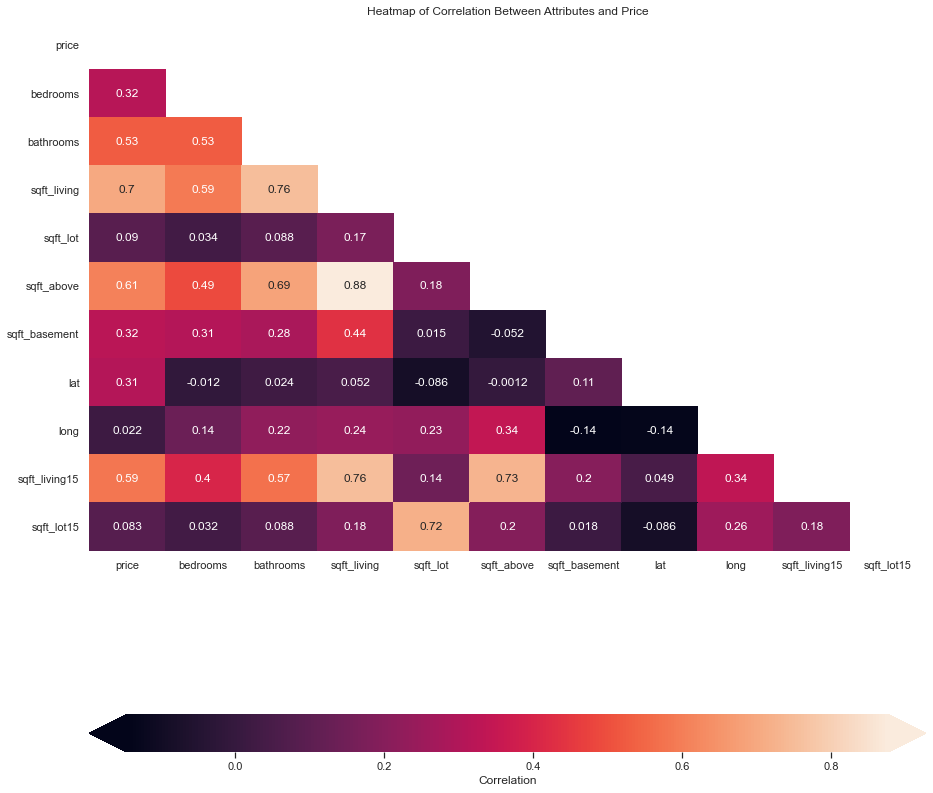

In [29]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df[numeric]
y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [30]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701929
grade            0.667964
sqft_above       0.605392
sqft_living15    0.585267
bathrooms        0.525915
view             0.393502
sqft_basement    0.323794
bedrooms         0.315961
lat              0.306687
waterfront       0.264308
floors           0.256820
if_renovated     0.117546
sqft_lot         0.089879
sqft_lot15       0.082849
age_of_house     0.053901
zipcode          0.053409
condition        0.036031
long             0.022047
month_of_date    0.009926
Name: price, dtype: float64

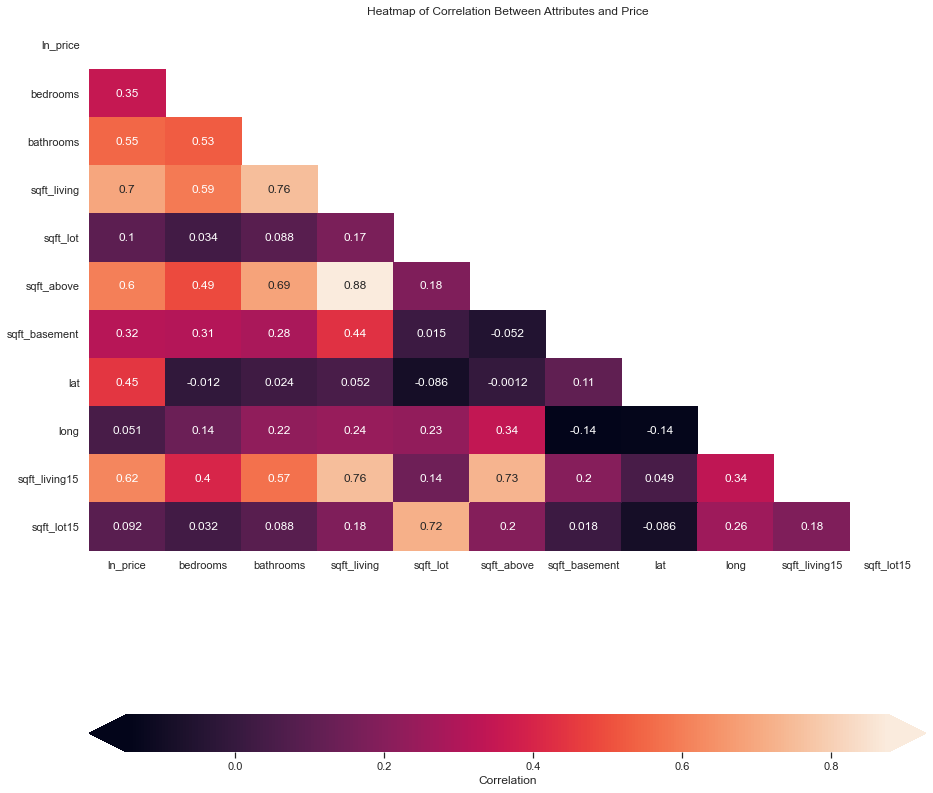

In [31]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df[numeric]
ln_y = df['ln_price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [32]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703747
sqft_living      0.695209
sqft_living15    0.619371
sqft_above       0.601621
bathrooms        0.551270
lat              0.448824
bedrooms         0.350871
view             0.344665
sqft_basement    0.316908
floors           0.310665
waterfront       0.170724
if_renovated     0.106534
sqft_lot         0.100032
sqft_lot15       0.092290
age_of_house     0.080523
long             0.050887
condition        0.038855
zipcode          0.038801
month_of_date    0.013058
Name: ln_price, dtype: float64

We reviewed the distribution of features and see if we need to log-transform the features.

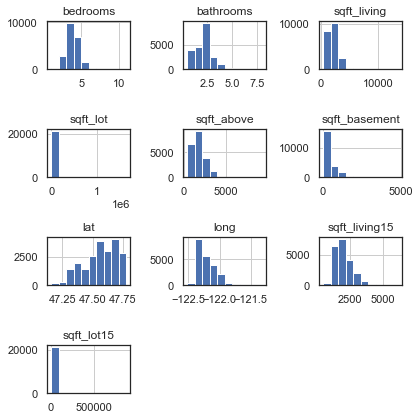

In [33]:
#plot the numeric features to see distribution and see if they need to be log-transformed
df[numeric].hist(figsize=[6,6]);
plt.tight_layout()
plt.show()

In [34]:
#log transform all numeric feature except:
#sqft basement - has values of 0
#long - has negative values
to_ln = ['bedrooms',
         'bathrooms',
         'sqft_living',
         'sqft_lot', 
         'sqft_above',
         'lat',
         'sqft_living15', 
         'sqft_lot15']

for column in to_ln:
    df[column] = np.log(df[column])

## Data Mainipulation

For this section, we focused on create an efficient way to take our cleaned dataframe and create train and test splits for each of our model.

In [35]:
#create two dataframes, one without ln_price, and without price
output = df.drop(['ln_price'], axis=1) 
output_ln = df.drop(['price'], axis=1) 

In [36]:
def train_test(df, target, test_size=0.20, random_state=42):
    '''
    This function takes in a dataframe df and target column and returns the train and test split
    Default test size is 20, default random state is 42
    '''
    
    df = pd.get_dummies(df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)
    
    #replace '.' with '_' in column names since sklearn LR has issues with '.'
    df.columns = [x.replace(".","_") for x in df.columns]

    #dropping targets out of predictors
    X = df.drop(target, axis=1)

    #set target with y
    y = df[target]
    
    #creating  train test split for model comparison
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    X_list = [X_train, X_test]
    
    #scaling X values into z-scores
    ss = StandardScaler()
    for i in X_list:
        ss.fit(i)
        i = pd.DataFrame(ss.transform(i))
        i.columns = X.columns
    
    return X_train, X_test, y_train, y_test

## Other Formulas and Useful Objects

We created several formulas to efficiently run repetitive processes, including running cross validation, checking for R-squared and RMSE, and plotting different linear regression assumption tests.

In [37]:
def cross_val(estimator,X,y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [38]:
#returns a summary of the median train R-squared, median test R-squared, and differential score based
#on the cross validation
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [39]:
def score_model(model, Xtrain, Xtest, ytrain, ytest, log=False):
    '''
    This function takes in a model and the train and test samples and returns
    the train R-squared, test R-squared, and the RMSE
    '''
    if log == False:
        rmse = mean_squared_error(ytest, model.predict(Xtest), squared=False)
    else:
        rmse = mean_squared_error(np.exp(ytest), np.exp(model.predict(Xtest)), squared=False)
    return model.score(Xtrain, ytrain),  model.score(Xtest, ytest), rmse

In [40]:
#returns a summary of the train R-squared, test R-squared, differential between R-squared, and RMSE
def model_summary(train,test,diff,rmse):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-squared value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}. The RMSE of our model predicitons was {round(rmse,2)}"

In [41]:
def normality_test(ols_model):
    """
    tests for normality by taking in an OLS model, and reporting out different test features
    and plots the Q-Q plot
    """
    residuals = ols_model.resid
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(residuals)
    for name, test in zip(name, test):
        print('\n',name, '----')
        print(test)
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    fig.show();

In [42]:
def homoscedasticity_test(ols_model):
    """
    tests for homoscedasticity by taking in an OLS model, and reporting out different test features
    and plots residual vs fitted plot
    """
    predicted_y = ols_model.predict()
    resids = ols_model.resid

    fig, ax = plt.subplots()

    sns.regplot(x=predicted_y, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
    ax.set_title('Residuals vs Fitted', fontsize=16)
    ax.set(xlabel='Fitted Values', ylabel='Residuals')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, ols_model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, ols_model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plot ----')

In [43]:
def actual_vs_predicted(model,X_test,y_test):
    """
    Plots the actual y vs the predicted y
    """
    y_predicted = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=y_test, y=y_predicted)
    ax.set_xlabel("Actual Price Values")
    ax.set_ylabel("Predicted Price Values")
    ax.set_title("Actual vs Predicted")
    
    p1 = max(max(y_test), max(y_predicted))
    p2 = min(min(y_test), min(y_predicted))
    plt.plot([p1, p2], [p1, p2], 'b-')

In [44]:
def plot_cooks_distance(c):
    """
    takes in cook's distance data and plots the cook's distance
    """
    _, ax = plt.subplots(figsize=(6,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance")
    return ax

## Baseline Model

For the baseline model, we used a Dummy Regressor model which takes the mean of the price as the y-predicted value

### Baseline: Target Price

In [45]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output, 'price')

#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train,y_train);

In [46]:
#setting up cross validation for price in a different way (x3)
bmodel_cval = cross_val(baseline_model,
                        X=X_train,
                        y=y_train,
                        random_state=0)

bmodel_cval_summary = cval_summary(bmodel_cval[0],
                                   bmodel_cval[1],
                                   abs(bmodel_cval[0]-bmodel_cval[1]))
bmodel_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00014'

In [47]:
baseline_scores = score_model(baseline_model,
                              X_train,
                              X_test,
                              y_train,
                              y_test)

In [48]:
baseline_summary = model_summary(baseline_scores[0],
                                 baseline_scores[1],
                                 abs(baseline_scores[0]-baseline_scores[1]),
                                 baseline_scores[2])
baseline_summary

'The R-squared value for the train set was 0.0, and the R-squared value for the test set was -0.0. These values resulted in a differential of 0.00016. The RMSE of our model predicitons was 361985.86'

### Baseline: Target Log-transformed Price

In [49]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create `a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train,y_train);

In [50]:
bmodel_ln_cval = cross_val(baseline_ln_model,
                           X=X_train,
                           y=y_train,
                           random_state=0)

bmodel_ln_cval_summary = cval_summary(bmodel_ln_cval[0],
                                      bmodel_ln_cval[1], 
                                      abs(bmodel_ln_cval[0]-bmodel_ln_cval[1]))
bmodel_ln_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00015'

In [51]:
baseline_ln_scores = score_model(baseline_ln_model,
                                 X_train,
                                 X_test,
                                 y_train,
                                 y_test,
                                 log=True)

baseline_ln_scores

(0.0, -0.00010221773342600216, 369029.04857828317)

In [52]:
baseline_ln_summary = model_summary(baseline_ln_scores[0],
                                    baseline_ln_scores[1],
                                    abs(baseline_ln_scores[0]-baseline_ln_scores[1]),
                                    baseline_ln_scores[2])
baseline_ln_summary

'The R-squared value for the train set was 0.0, and the R-squared value for the test set was -0.0. These values resulted in a differential of 0.0001. The RMSE of our model predicitons was 369029.05'

### Summary

After running cross validation with both of our baseline models to ensure data integrity, we found from the results of our regression R-squared scores that the fit of the data we found that the cross-validation, train and test scores were all near 0. This is to be expected of the baseline model due to it's horizontal nature. Exactly 0% of the variation in y train is predicted by a horizontal line through the mean and 100% of it is due to variance.

>The miniscule inscrease in R-squared for the test set is due to the slight change in mean from the train to test sets.

The RMSE for the baseline model was approximately 360-370K.

## Model 1

Model 1 uses a multiple linear regression model of the data using all features, including the dummied out categorical features.

### Model 1: Target Price

We analyzed the untransformed price data set.

In [53]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output, 'price')

#create linear regression model for price and setting up cross validation 
model1 = LinearRegression()
model1.fit(X_train, y_train);

In [54]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.837, the median R-squared values for the test sets were 0.83. These values resulted in a differential of 0.007'

In [55]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.836, and the R-squared value for the test set was 0.806. These values resulted in a differential of 0.0307. The RMSE of our model predicitons was 159586.6'

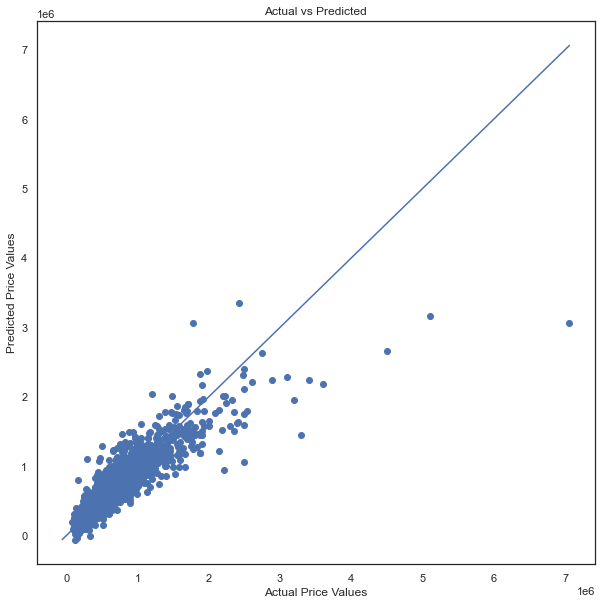

In [56]:
actual_vs_predicted(model1, X_test, y_test)

We see from the Actual vs Predicted plot that though most of the data points seems to be clustered around the benchmark, there are noticeable outliers.

### Model 1: Target Price - OLS and Assumption Tests

We find the OLS of the model to review the p values across all features and use the OLS model to run assumption tests

In [57]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ols = sm.OLS(y_train, X_train).fit()

In [58]:
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     755.7
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:26:03   Log-Likelihood:            -2.3032e+05
No. Observations:               17276   AIC:                         4.609e+05
Df Residuals:                   17159   BIC:                         4.618e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.328e+07   1.31e+07     -5.597      0.000   -9.89e+07   -4.76e+07
bedrooms         -1.966e+04   5674.515     -3.465      0.001   -3.08e+04   -8539.234
bathrooms         3.327e+04   5472.637      6.080      0.000    2.25e+04     4.4e+04
sqft_living      -2.338e+05   1.64e+04    -14.266      0.000   -2.66e+05   -2.02e+05
sqft_lot          3.668e+04   3374.128     10.871      0.000    3.01e+04    4.33e+04
sqft_above        4.506e+05   1.46e+04     30.763      0.000    4.22e+05    4.79e+05
sqft_basement      205.1065      7.665     26.758      0.000     190.082     220.131
lat                 1.2e+07   3.14e+06      3.823      0.000    5.85e+06    1.81e+07
long             -2.059e+05   4.71e+04     -4.370      0.000   -2.98e+05   -1.14e+05
sqft_living15      5.45e+04   6290.855      8.663      0.000    4.22e+04    6.68e+04
sqft_lot15       -1.652e+04   3713.646     -4.450      0.000   -2.38e+04   -9245.181
age_of_house       -73.3669     74.724     -0.982      0.326    -219.834      73.101
floors_1_5       -1.496e+04   4728.987     -3.163      0.002   -2.42e+04   -5687.674
floors_2_0       -1.326e+04   4070.411     -3.257      0.001   -2.12e+04   -5280.578
floors_2_5        7.871e+04   1.41e+04      5.574      0.000     5.1e+04    1.06e+05
floors_3_0       -6.858e+04   8905.293     -7.701      0.000    -8.6e+04   -5.11e+04
floors_3_5         1.81e+04   5.71e+04      0.317      0.751   -9.38e+04     1.3e+05
waterfront_1      5.844e+05   1.71e+04     34.150      0.000    5.51e+05    6.18e+05
view_1            9.487e+04   9684.444      9.796      0.000    7.59e+04    1.14e+05
view_2            6.066e+04   5898.433     10.284      0.000    4.91e+04    7.22e+04
view_3            1.438e+05   8054.789     17.855      0.000    1.28e+05     1.6e+05
view_4            2.814e+05   1.18e+04     23.778      0.000    2.58e+05    3.05e+05
condition_2       8.726e+04    3.6e+04      2.424      0.015    1.67e+04    1.58e+05
condition_3       1.006e+05   3.39e+04      2.965      0.003    3.41e+04    1.67e+05
condition_4       1.261e+05    3.4e+04      3.714      0.000    5.96e+04    1.93e+05
condition_5        1.81e+05   3.41e+04      5.303      0.000    1.14e+05    2.48e+05
grade_4           -1.58e+05   1.54e+05     -1.025      0.305    -4.6e+05    1.44e+05
grade_5          -1.902e+05   1.51e+05     -1.262      0.207   -4.85e+05    1.05e+05
grade_6          -2.123e+05    1.5e+05     -1.412      0.158   -5.07e+05    8.24e+04
grade_7            -2.2e+05    1.5e+05     -1.463      0.144   -5.15e+05    7.48e+04
grade_8          -2.004e+05    1.5e+05     -1.332      0.183   -4.95e+05    9.45e+04
grade_9          -1.037e+05   1.51e+05     -0.689      0.491   -3.99e+05    1.91e+05
grade_10          4.986e+04   1.51e+05      0.331      0.741   -2.45e+05    3.45e+05
grade_11           3.06


 Jarque-Bera ----
1142842.4719306459

 Prob ----
0.0

 Skew ----
2.7188772758070834

 Kurtosis ----
42.47251635922764


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


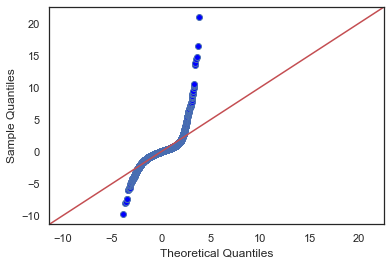

In [59]:
#test for normality
normality_test(model1_ols);

We can clearly see from the Q-Q plot that this model is not normal, and that is further validated by the high Jarque-Bera score.


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  4563.790739
p-value                           0.000000
f-value                          53.105399
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.910440
p-value      0.999993

 Residuals plot ----


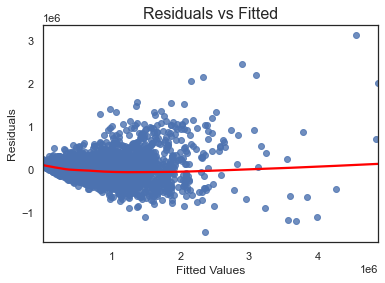

In [60]:
#test for homoscedasticity
homoscedasticity_test(model1_ols)

The Residual vs Fitted plot also shows that the data is heteroscedastic.

### Model 1: Target Price - Influence and Outliers

In order to reduce the RMSE, we tried to find any outliers within the dataset using Cook's Distance, which identifies any influential outliers, and removed them. We apply the same methodology to the test sample as we did to the train as well.

In [61]:
#find the cooks distance
inf = influence(model1_ols)
C, P = inf.cooks_distance

<AxesSubplot:title={'center':"Cook's Distance"}, xlabel='instance', ylabel='distance'>

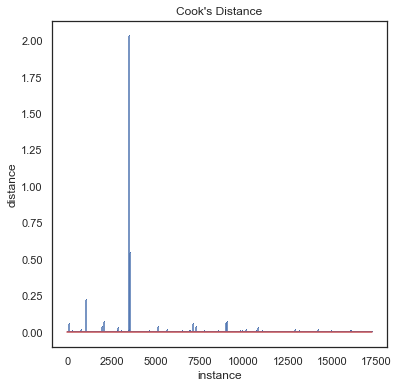

In [62]:
#plot cooks distance
plot_cooks_distance(C)

In [63]:
#create a new dataframe from main dataframe
train_df = pd.concat([y_train, X_train], axis=1)

#add new column for cooks distance
train_df['influence'] = C

In [64]:
#using the IQR rule, check what proportion of influence are outliers
quantile_75 = train_df['influence'].quantile(0.75)
quantile_25 = train_df['influence'].quantile(0.25)
iqr = quantile_75-quantile_25

elim_train_df = train_df[(train_df['influence'] > quantile_75 + 3*iqr) | 
                         (train_df['influence'] < quantile_25 - 3*iqr)]

In [65]:
#find the indexes related to the top x rows by cooks distance
list_index = list(elim_train_df.index)

#what proportion of df are we removing
print(round(len(elim_train_df)/len(train_df),2))

0.1


In [66]:
#drop any rows with the index of top x rows by cooks distance
#removes the influence and const columns for proper retesting in the next section
train_df.drop(index=list_index, inplace=True)
train_df.drop(columns=['influence','const'], inplace=True)

We apply what we did to the train sample to the test sample below:

### Model 1: Target Price - Retesting Based on Removed Outliers

Here, we are refiting the training sample after dropping the outliers and rerunning the linear regression

In [67]:
#split data into train and test
X_train = train_df.drop(['price'], axis = 1)
y_train = train_df['price']

In [68]:
#create linear regression model for price and setting up cross validation 
model1_adj = LinearRegression()
model1_adj.fit(X_train, y_train);

In [69]:
#setting up cross validation for price in a different way 
model1_adj_cval = cross_val(model1_adj,
                        X=X_train,
                        y=y_train,
                        random_state=0)

model1_adj_cval_summary = cval_summary(model1_adj_cval[0],
                                   model1_adj_cval[1],
                                   abs(model1_adj_cval[0]-model1_adj_cval[1]))
model1_adj_cval_summary

'The median R-squared values for the train sets were 0.908, the median R-squared values for the test sets were 0.906. These values resulted in a differential of 0.00243'

In [70]:
model1_adj_scores = score_model(model1_adj,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_adj_summary = model_summary(model1_adj_scores[0],
                               model1_adj_scores[1],
                               abs(model1_adj_scores[0]-model1_adj_scores[1]),
                               model1_adj_scores[2])
model1_adj_summary

'The R-squared value for the train set was 0.908, and the R-squared value for the test set was 0.799. These values resulted in a differential of 0.10882. The RMSE of our model predicitons was 162325.76'

We see that though the R-squared train set is higher than that of the previous analysis with the outliers, the test R-squared is lower. The RMSE is also lower. 

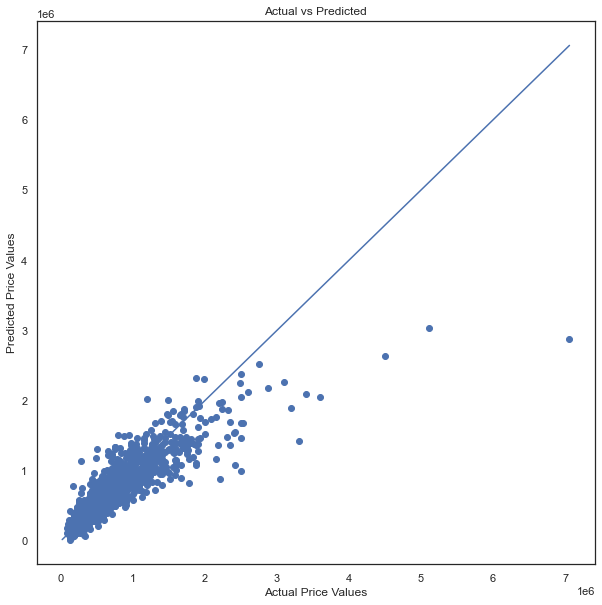

In [71]:
actual_vs_predicted(model1_adj, X_test, y_test)

In [72]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_adj_ols = sm.OLS(y_train, X_train).fit()

In [73]:
model1_adj_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1338.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:26:31   Log-Likelihood:            -1.9718e+05
No. Observations:               15627   AIC:                         3.946e+05
Df Residuals:                   15512   BIC:                         3.955e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.639e+07   6.15e+06     -5.918      0.000   -4.84e+07   -2.43e+07
bedrooms         -1.051e+04   2979.279     -3.527      0.000   -1.63e+04   -4667.983
bathrooms         1.901e+04   2836.872      6.700      0.000    1.34e+04    2.46e+04
sqft_living      -1.076e+05   9705.077    -11.091      0.000   -1.27e+05   -8.86e+04
sqft_lot          3.099e+04   1847.201     16.777      0.000    2.74e+04    3.46e+04
sqft_above        2.874e+05   8752.692     32.835      0.000     2.7e+05    3.05e+05
sqft_basement      138.6568      4.947     28.026      0.000     128.959     148.354
lat               6.022e+06   1.63e+06      3.699      0.000    2.83e+06    9.21e+06
long             -1.283e+05   2.54e+04     -5.061      0.000   -1.78e+05   -7.86e+04
sqft_living15     4.968e+04   3325.783     14.937      0.000    4.32e+04    5.62e+04
sqft_lot15       -1.119e+04   2003.295     -5.584      0.000   -1.51e+04   -7259.160
age_of_house       -53.3411     40.206     -1.327      0.185    -132.149      25.467
floors_1_5       -2108.5305   2477.252     -0.851      0.395   -6964.234    2747.173
floors_2_0       -2079.8666   2136.296     -0.974      0.330   -6267.257    2107.524
floors_2_5        6.715e+04   1.05e+04      6.419      0.000    4.66e+04    8.77e+04
floors_3_0       -5.431e+04   4698.851    -11.558      0.000   -6.35e+04   -4.51e+04
floors_3_5        2.482e+04    5.2e+04      0.477      0.633   -7.72e+04    1.27e+05
waterfront_1      5.994e+05      2e+04     29.979      0.000     5.6e+05    6.39e+05
view_1            7.837e+04   5782.097     13.554      0.000     6.7e+04    8.97e+04
view_2            5.924e+04   3251.202     18.219      0.000    5.29e+04    6.56e+04
view_3            1.321e+05   5045.230     26.186      0.000    1.22e+05    1.42e+05
view_4            2.741e+05   9440.576     29.039      0.000    2.56e+05    2.93e+05
condition_2       6.858e+04   3.38e+04      2.027      0.043    2261.233    1.35e+05
condition_3       9.287e+04   3.32e+04      2.801      0.005    2.79e+04    1.58e+05
condition_4       1.123e+05   3.32e+04      3.384      0.001    4.72e+04    1.77e+05
condition_5       1.555e+05   3.32e+04      4.682      0.000    9.04e+04    2.21e+05
grade_4          -4.231e+06   6.83e+05     -6.193      0.000   -5.57e+06   -2.89e+06
grade_5          -4.264e+06   6.83e+05     -6.242      0.000    -5.6e+06   -2.93e+06
grade_6          -4.273e+06   6.83e+05     -6.254      0.000   -5.61e+06   -2.93e+06
grade_7          -4.268e+06   6.83e+05     -6.247      0.000   -5.61e+06   -2.93e+06
grade_8          -4.238e+06   6.83e+05     -6.203      0.000   -5.58e+06    -2.9e+06
grade_9          -4.143e+06   6.83e+05     -6.064      0.000   -5.48e+06    -2.8e+06
grade_10         -4.018e+06   6.83e+05     -5.881      0.000   -5.36e+06   -2.68e+06
grade_11         -3.717


 Jarque-Bera ----
391.6698086225466

 Prob ----
8.912133708003742e-86

 Skew ----
0.2495050696380397

 Kurtosis ----
3.593731177707216


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


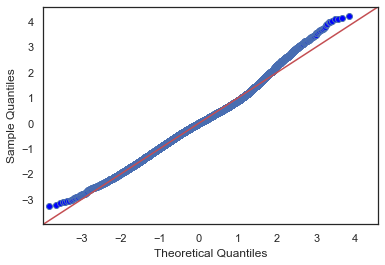

In [74]:
#test for normality
normality_test(model1_adj_ols);


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2570.226521
p-value                           0.000000
f-value                          26.785421
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  1.000478
p-value      0.491630

 Residuals plot ----


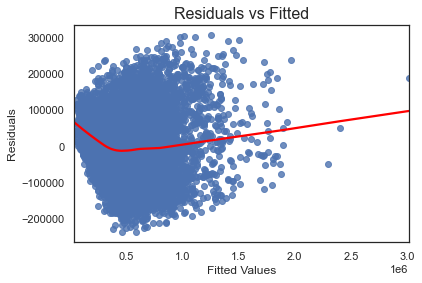

In [75]:
#test for homoscedasticity
homoscedasticity_test(model1_adj_ols)

### Model 1: Target Log-transformed Price

We repeat Model 1 for the log-transformed price data.

In [76]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create linear regression model for ln price
model1_ln= LinearRegression()
model1_ln.fit(X_train, y_train);

In [77]:
#setting up cross validation
model1_ln_cval = cross_val(model1_ln,
                           X=X_train,
                           y=y_train,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                      model1_ln_cval[1],
                                      abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

'The median R-squared values for the train sets were 0.889, the median R-squared values for the test sets were 0.888. These values resulted in a differential of 0.00104'

In [78]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln,
                             X_train,
                             X_test,
                             y_train,
                             y_test,
                             log=True)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]),
                                  model1_ln_scores[2])
model1_ln_summary

'The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00697. The RMSE of our model predicitons was 122558.91'

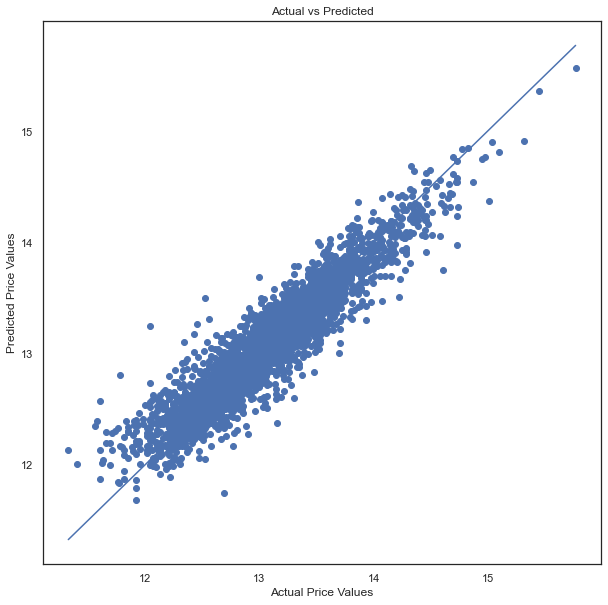

In [79]:
actual_vs_predicted(model1_ln, X_test, y_test)

### Model 1: Log-transformed Price - OLS and Assumption Tests

In [80]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ln_ols = sm.OLS(y_train, X_train).fit()

In [81]:
model1_ln_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:26:51   Log-Likelihood:                 5513.8
No. Observations:               17276   AIC:                        -1.079e+04
Df Residuals:                   17159   BIC:                            -9886.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -145.6449     15.434     -9.437      0.000    -175.897    -115.393
bedrooms            -0.0468      0.007     -6.993      0.000      -0.060      -0.034
bathrooms            0.0575      0.006      8.910      0.000       0.045       0.070
sqft_living          0.2779      0.019     14.387      0.000       0.240       0.316
sqft_lot             0.0742      0.004     18.644      0.000       0.066       0.082
sqft_above           0.1536      0.017      8.893      0.000       0.120       0.187
sqft_basement     9.356e-06   9.04e-06      1.035      0.301   -8.36e-06    2.71e-05
lat                 25.7455      3.699      6.959      0.000      18.494      32.997
long                -0.4419      0.056     -7.956      0.000      -0.551      -0.333
sqft_living15        0.1579      0.007     21.294      0.000       0.143       0.172
sqft_lot15          -0.0217      0.004     -4.962      0.000      -0.030      -0.013
age_of_house     -1.673e-05   8.81e-05     -0.190      0.849      -0.000       0.000
floors_1_5           0.0063      0.006      1.136      0.256      -0.005       0.017
floors_2_0          -0.0090      0.005     -1.870      0.061      -0.018       0.000
floors_2_5           0.0047      0.017      0.281      0.779      -0.028       0.037
floors_3_0          -0.0845      0.010     -8.045      0.000      -0.105      -0.064
floors_3_5          -0.0667      0.067     -0.991      0.322      -0.199       0.065
waterfront_1         0.4570      0.020     22.656      0.000       0.417       0.497
view_1               0.1252      0.011     10.964      0.000       0.103       0.148
view_2               0.1016      0.007     14.606      0.000       0.088       0.115
view_3               0.1753      0.009     18.463      0.000       0.157       0.194
view_4               0.2847      0.014     20.408      0.000       0.257       0.312
condition_2          0.1887      0.042      4.446      0.000       0.106       0.272
condition_3          0.3080      0.040      7.697      0.000       0.230       0.386
condition_4          0.3500      0.040      8.741      0.000       0.271       0.428
condition_5          0.4204      0.040     10.447      0.000       0.341       0.499
grade_4             -0.6136      0.182     -3.376      0.001      -0.970      -0.257
grade_5             -0.5419      0.178     -3.051      0.002      -0.890      -0.194
grade_6             -0.4891      0.177     -2.759      0.006      -0.837      -0.142
grade_7             -0.4203      0.177     -2.370      0.018      -0.768      -0.073
grade_8             -0.3407      0.177     -1.921      0.055      -0.688       0.007
grade_9             -0.2230      0.177     -1.257      0.209      -0.571       0.125
grade_10            -0.1348      0.178     -0.759      0.448      -0.483       0.213
grade_11            -0.


 Jarque-Bera ----
5620.136414139052

 Prob ----
0.0

 Skew ----
-0.22139888947387057

 Kurtosis ----
5.758891525662995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


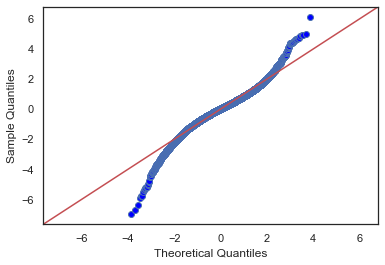

In [82]:
#test for normality
normality_test(model1_ln_ols);


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.669191e+03
p-value                        3.068687e-273
f-value                         1.582070e+01
f p-value                      1.795332e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.960020
p-value      0.970156

 Residuals plot ----


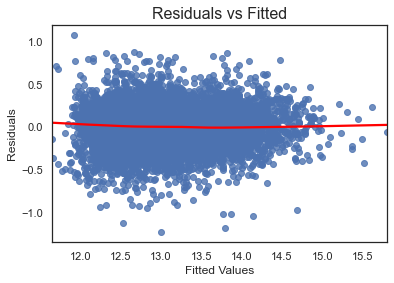

In [83]:
#test for homoscedasticity
homoscedasticity_test(model1_ln_ols)

### Model 1: Log-transformed Price  - Influence and Outliers

In [84]:
#find the cooks distance
inf = influence(model1_ln_ols)
C, P = inf.cooks_distance

<AxesSubplot:title={'center':"Cook's Distance"}, xlabel='instance', ylabel='distance'>

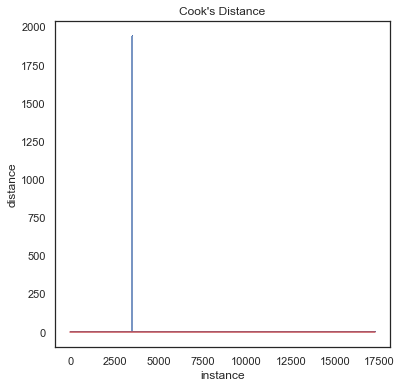

In [85]:
#plot cooks distance
plot_cooks_distance(C)

In [86]:
#create a new dataframe from main dataframe
train_df = pd.concat([y_train, X_train], axis=1)

#add new column for cooks distance
train_df['influence'] = C

In [87]:
#using the IQR rule, check what proportion of influence are outliers
quantile_75 = train_df['influence'].quantile(0.75)
quantile_25 = train_df['influence'].quantile(0.25)
iqr = quantile_75-quantile_25

elim_train_df = train_df[(train_df['influence'] > quantile_75 + 3*iqr) | 
                       (train_df['influence'] < quantile_25 - 3*iqr)]


In [88]:
#find the indexes related to the top x rows by cooks distance
list_index = list(elim_train_df.index)

#what proportion of df are we removing
print(round(len(elim_train_df)/len(train_df),2))

0.07


In [89]:
#drop any rows with the index of top x rows by cooks distance and any nulls
train_df.drop(index=list_index, inplace=True)
train_df.drop(columns=['influence','const'], inplace=True)

### Model 1: Log-transformed Price  - Retesting Based on Removed Outliers

In [90]:
#split data into train and test
X_train = train_df.drop(['ln_price'], axis = 1)
y_train = train_df['ln_price']

#create linear regression model for ln price
model1_ln_adj= LinearRegression()
model1_ln_adj.fit(X_train, y_train);

In [91]:
#setting up cross validation
model1_ln_adj_cval = cross_val(model1_ln_adj,
                           X=X_train,
                           y=y_train,
                           random_state=0)

model1_ln_adj_cval_summary = cval_summary(model1_ln_adj_cval[0],
                                      model1_ln_adj_cval[1],
                                      abs(model1_ln_adj_cval[0]-model1_ln_adj_cval[1]))
model1_ln_adj_cval_summary

'The median R-squared values for the train sets were 0.924, the median R-squared values for the test sets were 0.924. These values resulted in a differential of 0.00047'

In [92]:
#find the test score using the linear model
model1_ln_adj_scores = score_model(model1_ln_adj,
                             X_train,
                             X_test,
                             y_train,
                             y_test,
                             log=True)

model1_ln_adj_summary = model_summary(model1_ln_adj_scores[0],
                                  model1_ln_adj_scores[1],
                                  abs(model1_ln_adj_scores[0]-model1_ln_adj_scores[1]),
                                  model1_ln_adj_scores[2])
model1_ln_adj_summary

'The R-squared value for the train set was 0.924, and the R-squared value for the test set was 0.881. These values resulted in a differential of 0.0429. The RMSE of our model predicitons was 122885.44'

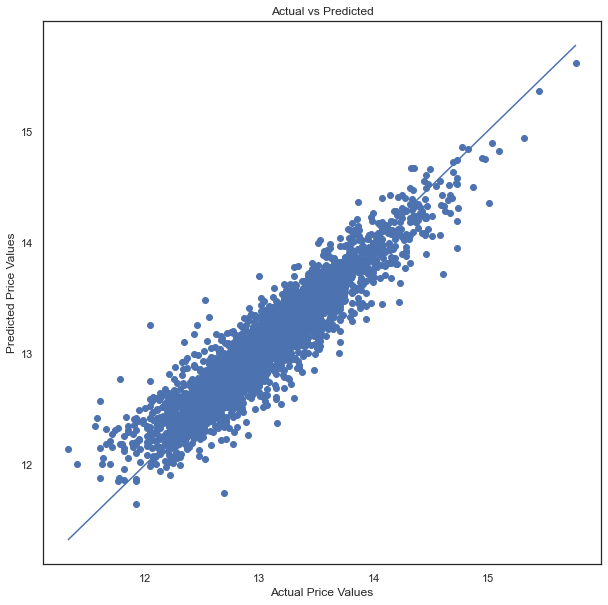

In [93]:
actual_vs_predicted(model1_ln_adj, X_test, y_test)

In [94]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ln_adj_ols = sm.OLS(y_train, X_train).fit()

In [95]:
model1_ln_adj_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1711.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:27:16   Log-Likelihood:                 9431.5
No. Observations:               16084   AIC:                        -1.863e+04
Df Residuals:                   15969   BIC:                        -1.775e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -102.6101     11.455     -8.958      0.000    -125.063     -80.158
bedrooms            -0.0366      0.005     -6.717      0.000      -0.047      -0.026
bathrooms            0.0520      0.005     10.008      0.000       0.042       0.062
sqft_living          0.2641      0.016     16.351      0.000       0.232       0.296
sqft_lot             0.0690      0.003     20.365      0.000       0.062       0.076
sqft_above           0.1660      0.014     11.490      0.000       0.138       0.194
sqft_basement     1.389e-05   7.73e-06      1.798      0.072   -1.25e-06     2.9e-05
lat                 22.1702      2.985      7.427      0.000      16.319      28.021
long                -0.2849      0.052     -5.427      0.000      -0.388      -0.182
sqft_living15        0.1513      0.006     25.099      0.000       0.139       0.163
sqft_lot15          -0.0193      0.004     -5.262      0.000      -0.027      -0.012
age_of_house     -9.818e-05   7.19e-05     -1.366      0.172      -0.000    4.27e-05
floors_1_5           0.0072      0.005      1.601      0.109      -0.002       0.016
floors_2_0          -0.0109      0.004     -2.852      0.004      -0.018      -0.003
floors_2_5          -0.0115      0.015     -0.775      0.438      -0.041       0.018
floors_3_0          -0.0977      0.008    -11.665      0.000      -0.114      -0.081
floors_3_5       -4.633e-12   5.18e-13     -8.949      0.000   -5.65e-12   -3.62e-12
waterfront_1         0.5029      0.019     25.834      0.000       0.465       0.541
view_1               0.1047      0.010     10.899      0.000       0.086       0.123
view_2               0.0981      0.006     17.396      0.000       0.087       0.109
view_3               0.1672      0.008     20.624      0.000       0.151       0.183
view_4               0.2709      0.013     21.663      0.000       0.246       0.295
condition_2          0.2306      0.097      2.373      0.018       0.040       0.421
condition_3          0.3674      0.096      3.827      0.000       0.179       0.556
condition_4          0.4015      0.096      4.182      0.000       0.213       0.590
condition_5          0.4751      0.096      4.947      0.000       0.287       0.663
grade_4            -10.6248      1.147     -9.267      0.000     -12.872      -8.377
grade_5            -10.5856      1.145     -9.242      0.000     -12.831      -8.341
grade_6            -10.5089      1.145     -9.174      0.000     -12.754      -8.264
grade_7            -10.4472      1.146     -9.120      0.000     -12.693      -8.202
grade_8            -10.3734      1.146     -9.055      0.000     -12.619      -8.128
grade_9            -10.2553      1.146     -8.952      0.000     -12.501      -8.010
grade_10           -10.1758      1.146     -8.882      0.000     -12.421      -7.930
grade_11           -10.


 Jarque-Bera ----
41.54286950003934

 Prob ----
9.529728039167671e-10

 Skew ----
-0.12448510281028463

 Kurtosis ----
2.998357004556791


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


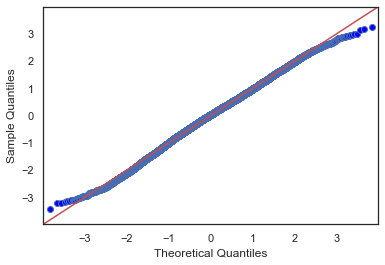

In [96]:
#test for normality
normality_test(model1_ln_adj_ols);


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.350510e+03
p-value                        2.822006e-209
f-value                         1.284000e+01
f p-value                      2.677701e-221

 Goldfeld-Quandt test ----
                value
F statistic  1.000326
p-value      0.494214

 Residuals plot ----


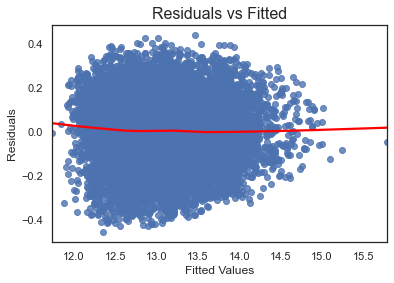

In [97]:
#test for homoscedasticity
homoscedasticity_test(model1_ln_adj_ols)

### Summary

In [98]:
print('\n Model 1: Untransformed Price, With Outliers ----')
print(model1_summary)
print('\n Model 1: Untransformed Price, Without Outliers ----')
print(model1_adj_summary)
print('\n Model 1: Log-Transformed Price, With Outliers ----')
print(model1_ln_summary)
print('\n Model 1: Log-Transformed Price, Without Outliers ----')
print(model1_ln_adj_summary)


 Model 1: Untransformed Price, With Outliers ----
The R-squared value for the train set was 0.836, and the R-squared value for the test set was 0.806. These values resulted in a differential of 0.0307. The RMSE of our model predicitons was 159586.6

 Model 1: Untransformed Price, Without Outliers ----
The R-squared value for the train set was 0.908, and the R-squared value for the test set was 0.799. These values resulted in a differential of 0.10882. The RMSE of our model predicitons was 162325.76

 Model 1: Log-Transformed Price, With Outliers ----
The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00697. The RMSE of our model predicitons was 122558.91

 Model 1: Log-Transformed Price, Without Outliers ----
The R-squared value for the train set was 0.924, and the R-squared value for the test set was 0.881. These values resulted in a differential of 0.0429. The RMSE of our model predicitons

We see from the various Model 1 analysis, the log-transformed price data had a higher R-squared value and lower RMSE than those of the non-transformed price data. In addition, after we removed the outliers from the train data, we noticed a higher train R-squared value, but a lower test R-Squared value and higher RMSE.

Therefore, we see that log-transformed price data with outliers is the best Model 1.

In [99]:
best_model1_summary = model1_ln_summary

## Model 2

In Model 2 we drop features that had a relatively high p-value (alpha = 0.05) from Model 1 ln price OLS with outliers removed to look for improvement in model fit.

### Model 2: Filtering by p-value

In [100]:
#create a dataframe for the parameters and pvalues
results = pd.DataFrame(model1_ln_ols.pvalues)
results.reset_index(inplace=True)

#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

#create a list of parameters that have a pvalue < 0.05
feat = results[results['pvalue'] < 0.05]
features = list(feat['parameter'])

#the intercept constant is not needed 
features.remove('const')

### Model 2: Fitting and Validation

We fit the data by running only the features selected above.

In [101]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create linear regression model for price and setting up cross validation (x3)
model2 = LinearRegression()
model2.fit(X_train[features], y_train);

In [102]:
#setting up cross validation
model2_cval = cross_val(model2,
                        X=X_train[features],
                        y=y_train,
                        random_state=0)

model2_cval_summary = cval_summary(model2_cval[0],
                                   model2_cval[1],
                                   abs(model2_cval[0]-model2_cval[1]))
model2_cval_summary

'The median R-squared values for the train sets were 0.879, the median R-squared values for the test sets were 0.878. These values resulted in a differential of 0.00105'

In [103]:
#find the test score using the linear model
model2_scores = score_model(model2,
                             X_train[features],
                             X_test[features],
                             y_train,
                             y_test,
                             log=True)

model2_summary = model_summary(model2_scores[0],
                               model2_scores[1],
                               abs(model2_scores[0]-model2_scores[1]),
                               model2_scores[2])
model2_summary

'The R-squared value for the train set was 0.879, and the R-squared value for the test set was 0.869. These values resulted in a differential of 0.00991. The RMSE of our model predicitons was 140511.22'

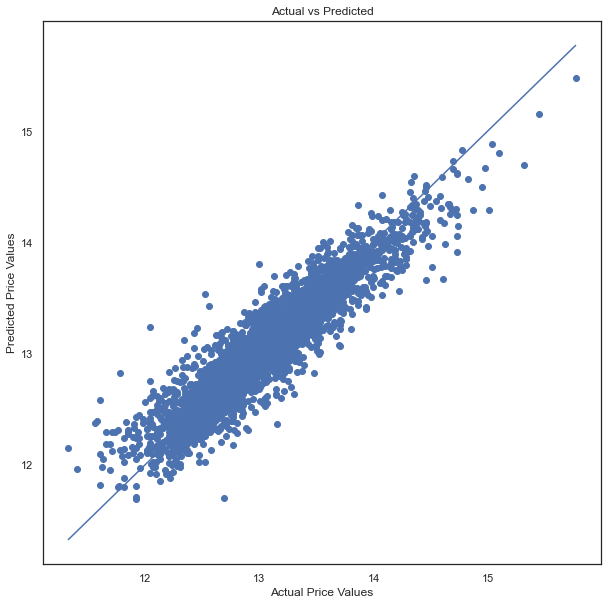

In [104]:
actual_vs_predicted(model2, X_test[features], y_test)

### Model 2: OLS and Assumption Tests

In [105]:
#add constant to X_train
X_train = sm.add_constant(X_train[features])

#find OLS for train data set
model2_ols = sm.OLS(y_train, X_train).fit()

In [106]:
model2_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     1368.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:27:40   Log-Likelihood:                 4758.8
No. Observations:               17276   AIC:                            -9334.
Df Residuals:                   17184   BIC:                            -8620.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -150.4993     11.362    -13.245      0.000    -172.771    -128.228
bedrooms           -0.0819      0.007    -11.947      0.000      -0.095      -0.068
bathrooms           0.0588      0.006      9.496      0.000       0.047       0.071
sqft_living         0.3321      0.009     35.773      0.000       0.314       0.350
sqft_lot            0.0774      0.004     19.079      0.000       0.069       0.085
sqft_above          0.1977      0.007     26.619      0.000       0.183       0.212
lat                27.9835      2.664     10.504      0.000      22.762      33.205
long               -0.3995      0.055     -7.263      0.000      -0.507      -0.292
sqft_living15       0.1953      0.008     25.603      0.000       0.180       0.210
sqft_lot15         -0.0154      0.005     -3.380      0.001      -0.024      -0.006
floors_3_0         -0.0648      0.010     -6.806      0.000      -0.083      -0.046
waterfront_1        0.4545      0.021     21.631      0.000       0.413       0.496
view_1              0.1290      0.012     10.873      0.000       0.106       0.152
view_2              0.1154      0.007     16.023      0.000       0.101       0.129
view_3              0.2038      0.010     20.820      0.000       0.185       0.223
view_4              0.3401      0.014     23.671      0.000       0.312       0.368
condition_2         0.2099      0.044      4.740      0.000       0.123       0.297
condition_3         0.3344      0.042      8.011      0.000       0.253       0.416
condition_4         0.3669      0.042      8.783      0.000       0.285       0.449
condition_5         0.4366      0.042     10.401      0.000       0.354       0.519
grade_4            -0.2092      0.043     -4.860      0.000      -0.294      -0.125
grade_5            -0.1552      0.015    -10.671      0.000      -0.184      -0.127
grade_6            -0.1167      0.007    -17.209      0.000      -0.130      -0.103
grade_7            -0.0805      0.004    -20.190      0.000      -0.088      -0.073
grade_13            0.5148      0.056      9.132      0.000       0.404       0.625
if_renovated_1      0.0573      0.008      7.241      0.000       0.042       0.073
zipcode_98004       0.9985      0.020     49.653      0.000       0.959       1.038
zipcode_98005       0.6144      0.023     26.224      0.000       0.569       0.660
zipcode_98006       0.5771      0.018     32.002      0.000       0.542       0.612
zipcode_98007       0.5456      0.025     21.914      0.000       0.497       0.594
zipcode_98008       0.5433      0.022     24.368      0.000       0.500       0.587
zipcode_98010       0.3053      0.026     11.713      0.000       0.254       0.356
zipcode_98011       0.1997      0.028      7.163      0.000       0.145       0.254
zipcode_98014       0.2196      0.037      5.984      0.000


 Jarque-Bera ----
4058.5874049444456

 Prob ----
0.0

 Skew ----
-0.11298843612359129

 Kurtosis ----
5.363718796904574


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


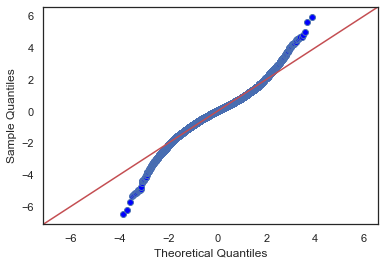

In [107]:
#test for normality
normality_test(model2_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.625614e+03
p-value                        1.867622e-279
f-value                         1.961441e+01
f p-value                      2.896442e-295

 Goldfeld-Quandt test ----
                value
F statistic  0.961160
p-value      0.966447

 Residuals plot ----


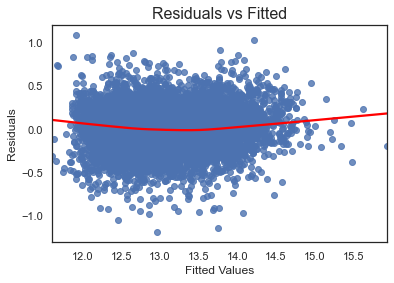

In [108]:
#test for homoscedasticity
homoscedasticity_test(model2_ols)

### Summary

In [109]:
print('\n Model 2: With Significant Features ----')
print(model2_summary)
print('\n Model 1: ----')
print(best_model1_summary)


 Model 2: With Significant Features ----
The R-squared value for the train set was 0.879, and the R-squared value for the test set was 0.869. These values resulted in a differential of 0.00991. The RMSE of our model predicitons was 140511.22

 Model 1: ----
The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00697. The RMSE of our model predicitons was 122558.91


Our fit on the data has dropped  by removing features containing p-values greater than 0.05. In light of this  decrease in accuracy we will still be relying on our "best" model 1.

## Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (RFE) of varying number of features to improve on the model.

### Model 3: Recursive Feature Elimination (RFE)

In [110]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

In [111]:
#determine how many features we have
len(X_train.columns)

116

We created a for loop to find the top column names based on varying n for the RFE.

In [112]:
#determine n for RFE
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #fit model to RFE
    select.fit(X=X_train, y=y_train)
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(X_train.columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns 

### Model 3: Testing 10 Features

In [113]:
#create linear regression model for price and setting up cross validation (x3)
model3_10 = LinearRegression()
model3_10.fit(X_train[key_cols['key_cols_10']], y_train);

In [114]:
#setting up cross validation for price in a different way (x3)
model3_10_cval = cross_val(model3_10,
                       X=X_train[key_cols['key_cols_10']],
                       y=y_train,
                       random_state=0,)

model3_10_cval_summary = cval_summary(model3_10_cval[0],
                                      model3_10_cval[1],
                                      abs(model3_10_cval[0]-model3_10_cval[1]))

model3_10_cval_summary

'The median R-squared values for the train sets were 0.713, the median R-squared values for the test sets were 0.711. These values resulted in a differential of 0.00136'

In [115]:
#find the test score using the linear model
model3_10_scores = score_model(model3_10,
                           X_train[key_cols['key_cols_10']],
                           X_test[key_cols['key_cols_10']],
                           y_train,
                           y_test,
                              log=True)

model3_10_summary = model_summary(model3_10_scores[0],
                                  model3_10_scores[1],
                                  abs(model3_10_scores[0]-model3_10_scores[1]),
                                  model3_10_scores[2])
model3_10_summary

'The R-squared value for the train set was 0.712, and the R-squared value for the test set was 0.708. These values resulted in a differential of 0.00439. The RMSE of our model predicitons was 192278.25'

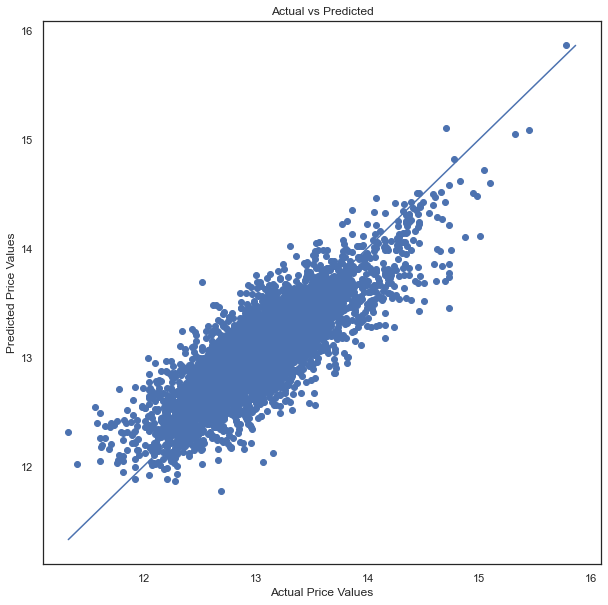

In [116]:
actual_vs_predicted(model3_10, X_test[key_cols['key_cols_10']], y_test)

In [117]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_10_ols = sm.OLS(y_train, X_train).fit()

In [118]:
model3_10_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:28:25   Log-Likelihood:                 5513.8
No. Observations:               17276   AIC:                        -1.079e+04
Df Residuals:                   17159   BIC:                            -9886.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -145.6449     15.434     -9.437      0.000    -175.897    -115.393
bedrooms            -0.0468      0.007     -6.993      0.000      -0.060      -0.034
bathrooms            0.0575      0.006      8.910      0.000       0.045       0.070
sqft_living          0.2779      0.019     14.387      0.000       0.240       0.316
sqft_lot             0.0742      0.004     18.644      0.000       0.066       0.082
sqft_above           0.1536      0.017      8.893      0.000       0.120       0.187
sqft_basement     9.356e-06   9.04e-06      1.035      0.301   -8.36e-06    2.71e-05
lat                 25.7455      3.699      6.959      0.000      18.494      32.997
long                -0.4419      0.056     -7.956      0.000      -0.551      -0.333
sqft_living15        0.1579      0.007     21.294      0.000       0.143       0.172
sqft_lot15          -0.0217      0.004     -4.962      0.000      -0.030      -0.013
age_of_house     -1.673e-05   8.81e-05     -0.190      0.849      -0.000       0.000
floors_1_5           0.0063      0.006      1.136      0.256      -0.005       0.017
floors_2_0          -0.0090      0.005     -1.870      0.061      -0.018       0.000
floors_2_5           0.0047      0.017      0.281      0.779      -0.028       0.037
floors_3_0          -0.0845      0.010     -8.045      0.000      -0.105      -0.064
floors_3_5          -0.0667      0.067     -0.991      0.322      -0.199       0.065
waterfront_1         0.4570      0.020     22.656      0.000       0.417       0.497
view_1               0.1252      0.011     10.964      0.000       0.103       0.148
view_2               0.1016      0.007     14.606      0.000       0.088       0.115
view_3               0.1753      0.009     18.463      0.000       0.157       0.194
view_4               0.2847      0.014     20.408      0.000       0.257       0.312
condition_2          0.1887      0.042      4.446      0.000       0.106       0.272
condition_3          0.3080      0.040      7.697      0.000       0.230       0.386
condition_4          0.3500      0.040      8.741      0.000       0.271       0.428
condition_5          0.4204      0.040     10.447      0.000       0.341       0.499
grade_4             -0.6136      0.182     -3.376      0.001      -0.970      -0.257
grade_5             -0.5419      0.178     -3.051      0.002      -0.890      -0.194
grade_6             -0.4891      0.177     -2.759      0.006      -0.837      -0.142
grade_7             -0.4203      0.177     -2.370      0.018      -0.768      -0.073
grade_8             -0.3407      0.177     -1.921      0.055      -0.688       0.007
grade_9             -0.2230      0.177     -1.257      0.209      -0.571       0.125
grade_10            -0.1348      0.178     -0.759      0.448      -0.483       0.213
grade_11            -0.


 Jarque-Bera ----
5620.136414139052

 Prob ----
0.0

 Skew ----
-0.22139888947387057

 Kurtosis ----
5.758891525662995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


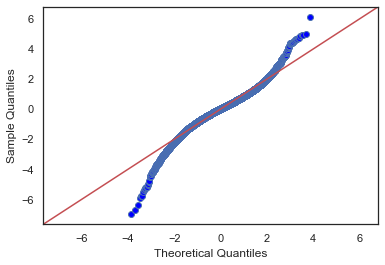

In [119]:
#test for normality
normality_test(model3_10_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.669191e+03
p-value                        3.068687e-273
f-value                         1.582070e+01
f p-value                      1.795332e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.960020
p-value      0.970156

 Residuals plot ----


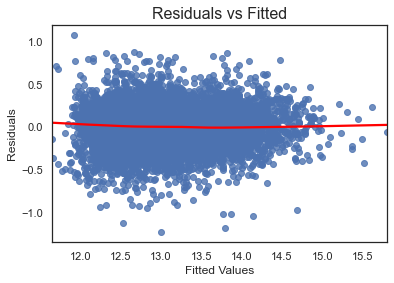

In [120]:
#test for homoscedasticity
homoscedasticity_test(model3_10_ols)

### Model 3: Testing 20 Features

In [121]:
#create linear regression model for price and setting up cross validation (x3)
model3_20 = LinearRegression()
model3_20.fit(X_train[key_cols['key_cols_20']], y_train);

In [122]:
#setting up cross validation for price in a different way (x3)
model3_20_cval = cross_val(model3_20,
                           X=X_train[key_cols['key_cols_20']],
                           y=y_train,
                           random_state=0,)

model3_20_cval_summary = cval_summary(model3_20_cval[0],
                                      model3_20_cval[1],
                                      abs(model3_20_cval[0]-model3_20_cval[1]))

model3_20_cval_summary

'The median R-squared values for the train sets were 0.775, the median R-squared values for the test sets were 0.774. These values resulted in a differential of 0.00019'

In [123]:
#find the test score using the linear model
model3_20_scores = score_model(model3_20,
                               X_train[key_cols['key_cols_20']],
                               X_test[key_cols['key_cols_20']],
                               y_train,
                               y_test,
                               log=True)

model3_20_summary = model_summary(model3_20_scores[0],
                                  model3_20_scores[1],
                                  abs(model3_20_scores[0]-model3_20_scores[1]),
                                  model3_20_scores[2])
model3_20_summary

'The R-squared value for the train set was 0.775, and the R-squared value for the test set was 0.76. These values resulted in a differential of 0.01456. The RMSE of our model predicitons was 176459.25'

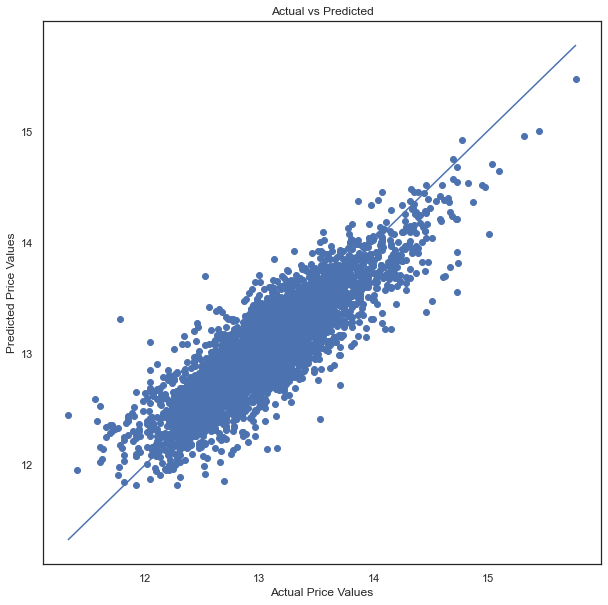

In [124]:
actual_vs_predicted(model3_20, X_test[key_cols['key_cols_20']], y_test)

In [125]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_20_ols = sm.OLS(y_train, X_train).fit()

In [126]:
model3_20_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:28:56   Log-Likelihood:                 5513.8
No. Observations:               17276   AIC:                        -1.079e+04
Df Residuals:                   17159   BIC:                            -9886.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -145.6449     15.434     -9.437      0.000    -175.897    -115.393
bedrooms            -0.0468      0.007     -6.993      0.000      -0.060      -0.034
bathrooms            0.0575      0.006      8.910      0.000       0.045       0.070
sqft_living          0.2779      0.019     14.387      0.000       0.240       0.316
sqft_lot             0.0742      0.004     18.644      0.000       0.066       0.082
sqft_above           0.1536      0.017      8.893      0.000       0.120       0.187
sqft_basement     9.356e-06   9.04e-06      1.035      0.301   -8.36e-06    2.71e-05
lat                 25.7455      3.699      6.959      0.000      18.494      32.997
long                -0.4419      0.056     -7.956      0.000      -0.551      -0.333
sqft_living15        0.1579      0.007     21.294      0.000       0.143       0.172
sqft_lot15          -0.0217      0.004     -4.962      0.000      -0.030      -0.013
age_of_house     -1.673e-05   8.81e-05     -0.190      0.849      -0.000       0.000
floors_1_5           0.0063      0.006      1.136      0.256      -0.005       0.017
floors_2_0          -0.0090      0.005     -1.870      0.061      -0.018       0.000
floors_2_5           0.0047      0.017      0.281      0.779      -0.028       0.037
floors_3_0          -0.0845      0.010     -8.045      0.000      -0.105      -0.064
floors_3_5          -0.0667      0.067     -0.991      0.322      -0.199       0.065
waterfront_1         0.4570      0.020     22.656      0.000       0.417       0.497
view_1               0.1252      0.011     10.964      0.000       0.103       0.148
view_2               0.1016      0.007     14.606      0.000       0.088       0.115
view_3               0.1753      0.009     18.463      0.000       0.157       0.194
view_4               0.2847      0.014     20.408      0.000       0.257       0.312
condition_2          0.1887      0.042      4.446      0.000       0.106       0.272
condition_3          0.3080      0.040      7.697      0.000       0.230       0.386
condition_4          0.3500      0.040      8.741      0.000       0.271       0.428
condition_5          0.4204      0.040     10.447      0.000       0.341       0.499
grade_4             -0.6136      0.182     -3.376      0.001      -0.970      -0.257
grade_5             -0.5419      0.178     -3.051      0.002      -0.890      -0.194
grade_6             -0.4891      0.177     -2.759      0.006      -0.837      -0.142
grade_7             -0.4203      0.177     -2.370      0.018      -0.768      -0.073
grade_8             -0.3407      0.177     -1.921      0.055      -0.688       0.007
grade_9             -0.2230      0.177     -1.257      0.209      -0.571       0.125
grade_10            -0.1348      0.178     -0.759      0.448      -0.483       0.213
grade_11            -0.


 Jarque-Bera ----
5620.136414139052

 Prob ----
0.0

 Skew ----
-0.22139888947387057

 Kurtosis ----
5.758891525662995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


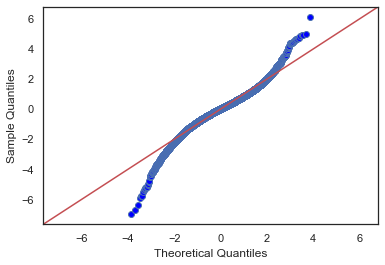

In [127]:
#test for normality
normality_test(model3_20_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.669191e+03
p-value                        3.068687e-273
f-value                         1.582070e+01
f p-value                      1.795332e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.960020
p-value      0.970156

 Residuals plot ----


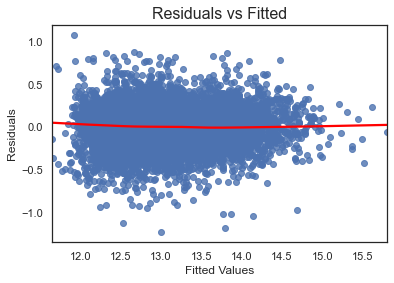

In [128]:
#test for homoscedasticity
homoscedasticity_test(model3_20_ols)

### Model 3: Testing 50 Features

In [129]:
#create linear regression model for price and setting up cross validation (x3)
model3_50 = LinearRegression()
model3_50.fit(X_train[key_cols['key_cols_50']], y_train);

In [130]:
#setting up cross validation for price in a different way (x3)
model3_50_cval = cross_val(model3_50,
                           X=X_train[key_cols['key_cols_50']],
                           y=y_train,
                           random_state=0,)

model3_50_cval_summary = cval_summary(model3_50_cval[0],
                                      model3_50_cval[1],
                                      abs(model3_50_cval[0]-model3_50_cval[1]))

model3_50_cval_summary

'The median R-squared values for the train sets were 0.859, the median R-squared values for the test sets were 0.857. These values resulted in a differential of 0.00137'

In [131]:
#find the test score using the linear model
model3_50_scores = score_model(model3_50,
                               X_train[key_cols['key_cols_50']],
                               X_test[key_cols['key_cols_50']],
                               y_train,
                               y_test,
                               log=True)

model3_50_summary = model_summary(model3_50_scores[0],
                                  model3_50_scores[1],
                                  abs(model3_50_scores[0]-model3_50_scores[1]),
                                  model3_50_scores[2])
model3_50_summary

'The R-squared value for the train set was 0.858, and the R-squared value for the test set was 0.85. These values resulted in a differential of 0.00847. The RMSE of our model predicitons was 150467.63'

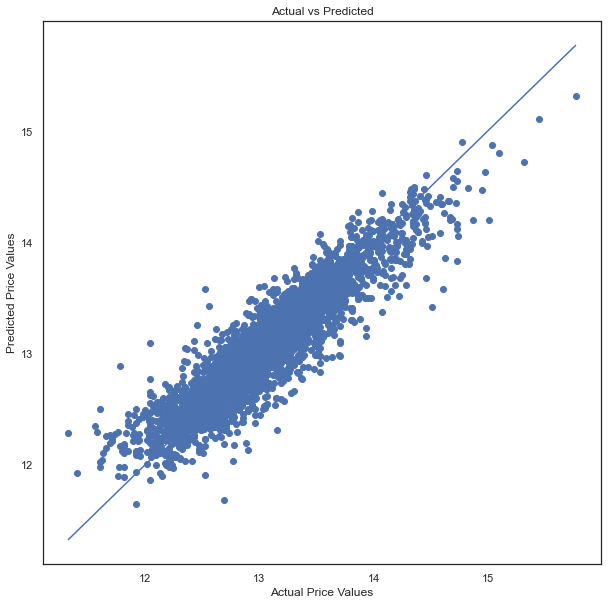

In [132]:
actual_vs_predicted(model3_50, X_test[key_cols['key_cols_50']], y_test)

In [133]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_50_ols = sm.OLS(y_train, X_train).fit()

In [134]:
model3_50_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:29:23   Log-Likelihood:                 5513.8
No. Observations:               17276   AIC:                        -1.079e+04
Df Residuals:                   17159   BIC:                            -9886.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -145.6449     15.434     -9.437      0.000    -175.897    -115.393
bedrooms            -0.0468      0.007     -6.993      0.000      -0.060      -0.034
bathrooms            0.0575      0.006      8.910      0.000       0.045       0.070
sqft_living          0.2779      0.019     14.387      0.000       0.240       0.316
sqft_lot             0.0742      0.004     18.644      0.000       0.066       0.082
sqft_above           0.1536      0.017      8.893      0.000       0.120       0.187
sqft_basement     9.356e-06   9.04e-06      1.035      0.301   -8.36e-06    2.71e-05
lat                 25.7455      3.699      6.959      0.000      18.494      32.997
long                -0.4419      0.056     -7.956      0.000      -0.551      -0.333
sqft_living15        0.1579      0.007     21.294      0.000       0.143       0.172
sqft_lot15          -0.0217      0.004     -4.962      0.000      -0.030      -0.013
age_of_house     -1.673e-05   8.81e-05     -0.190      0.849      -0.000       0.000
floors_1_5           0.0063      0.006      1.136      0.256      -0.005       0.017
floors_2_0          -0.0090      0.005     -1.870      0.061      -0.018       0.000
floors_2_5           0.0047      0.017      0.281      0.779      -0.028       0.037
floors_3_0          -0.0845      0.010     -8.045      0.000      -0.105      -0.064
floors_3_5          -0.0667      0.067     -0.991      0.322      -0.199       0.065
waterfront_1         0.4570      0.020     22.656      0.000       0.417       0.497
view_1               0.1252      0.011     10.964      0.000       0.103       0.148
view_2               0.1016      0.007     14.606      0.000       0.088       0.115
view_3               0.1753      0.009     18.463      0.000       0.157       0.194
view_4               0.2847      0.014     20.408      0.000       0.257       0.312
condition_2          0.1887      0.042      4.446      0.000       0.106       0.272
condition_3          0.3080      0.040      7.697      0.000       0.230       0.386
condition_4          0.3500      0.040      8.741      0.000       0.271       0.428
condition_5          0.4204      0.040     10.447      0.000       0.341       0.499
grade_4             -0.6136      0.182     -3.376      0.001      -0.970      -0.257
grade_5             -0.5419      0.178     -3.051      0.002      -0.890      -0.194
grade_6             -0.4891      0.177     -2.759      0.006      -0.837      -0.142
grade_7             -0.4203      0.177     -2.370      0.018      -0.768      -0.073
grade_8             -0.3407      0.177     -1.921      0.055      -0.688       0.007
grade_9             -0.2230      0.177     -1.257      0.209      -0.571       0.125
grade_10            -0.1348      0.178     -0.759      0.448      -0.483       0.213
grade_11            -0.


 Jarque-Bera ----
5620.136414139052

 Prob ----
0.0

 Skew ----
-0.22139888947387057

 Kurtosis ----
5.758891525662995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


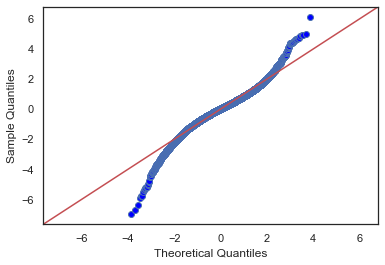

In [135]:
#test for normality
normality_test(model3_50_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.669191e+03
p-value                        3.068687e-273
f-value                         1.582070e+01
f p-value                      1.795332e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.960020
p-value      0.970156

 Residuals plot ----


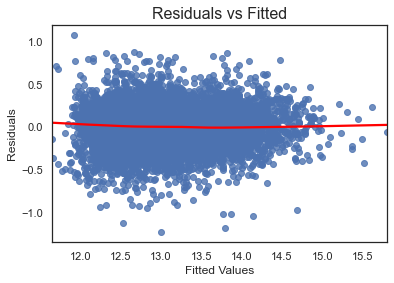

In [136]:
#test for homoscedasticity
homoscedasticity_test(model3_50_ols)

### Model 3: Testing 100 Features

In [137]:
#create linear regression model for price and setting up cross validation (x3)
model3_100 = LinearRegression()
model3_100.fit(X_train[key_cols['key_cols_100']], y_train);

In [138]:
#setting up cross validation for price in a different way (x3)
model3_100_cval = cross_val(model3_100,
                            X=X_train[key_cols['key_cols_100']],
                            y=y_train,
                            random_state=0,)

model3_100_cval_summary = cval_summary(model3_100_cval[0],
                                       model3_100_cval[1],
                                       abs(model3_100_cval[0]-model3_100_cval[1]))

model3_100_cval_summary

'The median R-squared values for the train sets were 0.889, the median R-squared values for the test sets were 0.888. These values resulted in a differential of 0.00068'

In [139]:
#find the test score using the linear model
model3_100_scores = score_model(model3_100,
                                X_train[key_cols['key_cols_100']],
                                X_test[key_cols['key_cols_100']],
                                y_train,
                                y_test,
                                log=True)

model3_100_summary = model_summary(model3_100_scores[0],
                                   model3_100_scores[1],
                                   abs(model3_100_scores[0]-model3_100_scores[1]),
                                   model3_100_scores[2])
model3_100_summary

'The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00688. The RMSE of our model predicitons was 122840.97'

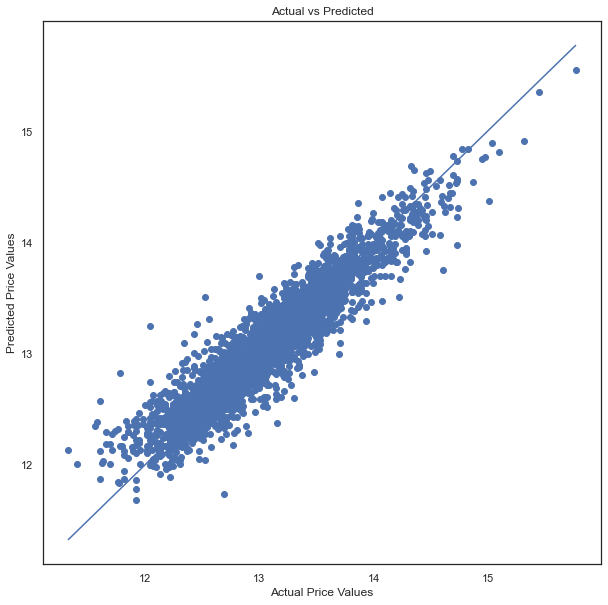

In [140]:
actual_vs_predicted(model3_100, X_test[key_cols['key_cols_100']], y_test)

In [141]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_100_ols = sm.OLS(y_train, X_train).fit()

In [142]:
model3_100_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:29:49   Log-Likelihood:                 5513.8
No. Observations:               17276   AIC:                        -1.079e+04
Df Residuals:                   17159   BIC:                            -9886.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -145.6449     15.434     -9.437      0.000    -175.897    -115.393
bedrooms            -0.0468      0.007     -6.993      0.000      -0.060      -0.034
bathrooms            0.0575      0.006      8.910      0.000       0.045       0.070
sqft_living          0.2779      0.019     14.387      0.000       0.240       0.316
sqft_lot             0.0742      0.004     18.644      0.000       0.066       0.082
sqft_above           0.1536      0.017      8.893      0.000       0.120       0.187
sqft_basement     9.356e-06   9.04e-06      1.035      0.301   -8.36e-06    2.71e-05
lat                 25.7455      3.699      6.959      0.000      18.494      32.997
long                -0.4419      0.056     -7.956      0.000      -0.551      -0.333
sqft_living15        0.1579      0.007     21.294      0.000       0.143       0.172
sqft_lot15          -0.0217      0.004     -4.962      0.000      -0.030      -0.013
age_of_house     -1.673e-05   8.81e-05     -0.190      0.849      -0.000       0.000
floors_1_5           0.0063      0.006      1.136      0.256      -0.005       0.017
floors_2_0          -0.0090      0.005     -1.870      0.061      -0.018       0.000
floors_2_5           0.0047      0.017      0.281      0.779      -0.028       0.037
floors_3_0          -0.0845      0.010     -8.045      0.000      -0.105      -0.064
floors_3_5          -0.0667      0.067     -0.991      0.322      -0.199       0.065
waterfront_1         0.4570      0.020     22.656      0.000       0.417       0.497
view_1               0.1252      0.011     10.964      0.000       0.103       0.148
view_2               0.1016      0.007     14.606      0.000       0.088       0.115
view_3               0.1753      0.009     18.463      0.000       0.157       0.194
view_4               0.2847      0.014     20.408      0.000       0.257       0.312
condition_2          0.1887      0.042      4.446      0.000       0.106       0.272
condition_3          0.3080      0.040      7.697      0.000       0.230       0.386
condition_4          0.3500      0.040      8.741      0.000       0.271       0.428
condition_5          0.4204      0.040     10.447      0.000       0.341       0.499
grade_4             -0.6136      0.182     -3.376      0.001      -0.970      -0.257
grade_5             -0.5419      0.178     -3.051      0.002      -0.890      -0.194
grade_6             -0.4891      0.177     -2.759      0.006      -0.837      -0.142
grade_7             -0.4203      0.177     -2.370      0.018      -0.768      -0.073
grade_8             -0.3407      0.177     -1.921      0.055      -0.688       0.007
grade_9             -0.2230      0.177     -1.257      0.209      -0.571       0.125
grade_10            -0.1348      0.178     -0.759      0.448      -0.483       0.213
grade_11            -0.


 Jarque-Bera ----
5620.136414139052

 Prob ----
0.0

 Skew ----
-0.22139888947387057

 Kurtosis ----
5.758891525662995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


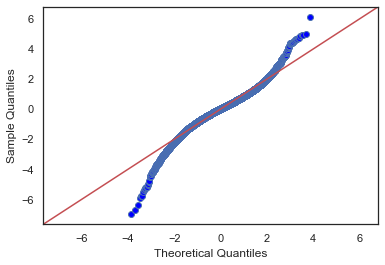

In [143]:
#test for normality
normality_test(model3_100_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.669191e+03
p-value                        3.068687e-273
f-value                         1.582070e+01
f p-value                      1.795332e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.960020
p-value      0.970156

 Residuals plot ----


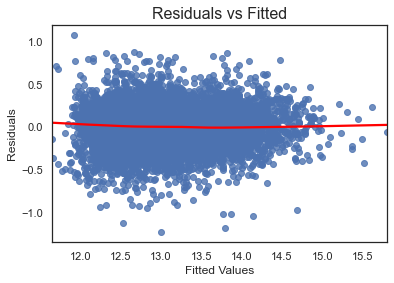

In [144]:
#test for homoscedasticity
homoscedasticity_test(model3_100_ols)

### Model 3: Summary

In [145]:
print('\n Model 3: Testing 10 Features ----')
print(model3_10_summary)
print('\n Model 3: Testing 20 Features ----')
print(model3_20_summary)
print('\n Model 3: Testing 50 Features ----')
print(model3_50_summary)
print('\n Model 3: Testing 100 Features ----')
print(model3_100_summary)
print('\n Model 1: ----')
print(best_model1_summary)


 Model 3: Testing 10 Features ----
The R-squared value for the train set was 0.712, and the R-squared value for the test set was 0.708. These values resulted in a differential of 0.00439. The RMSE of our model predicitons was 192278.25

 Model 3: Testing 20 Features ----
The R-squared value for the train set was 0.775, and the R-squared value for the test set was 0.76. These values resulted in a differential of 0.01456. The RMSE of our model predicitons was 176459.25

 Model 3: Testing 50 Features ----
The R-squared value for the train set was 0.858, and the R-squared value for the test set was 0.85. These values resulted in a differential of 0.00847. The RMSE of our model predicitons was 150467.63

 Model 3: Testing 100 Features ----
The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00688. The RMSE of our model predicitons was 122840.97

 Model 1: ----
The R-squared value for the train set

Looking at the score results above it becomes apparent that the trade off for removing features from our original model is a reduced R-squared statistic. It is interesting to note however, that although the 100 feature model's r-squared statistic is the same as that of Model 1, the differential between train and test was also more narrow. This trend continues down to 50 features and then the differential begins to rise again signaling that there may be some "best" number of features for balance between r-squared and the spread between test and train.

However, Model 1 still has a higher or similar R-squared score and a lower RMSE than those of the different versions of Model 3. Therefore, Model 1 is still our best model.

## Model 4

In Model 4, we utilized Binomial Feature Engineering.

### Model 4: Binomial Feature Engineering

In [146]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#setting up binomial features from Train/Test split that uses ln_price as a y value
pf = PolynomialFeatures(degree=2)
pf.fit(X_train);

In [147]:
#Training/tranforming the data using the fit pf object. Formatting as DataFrame for ease of use
pdf_train = pd.DataFrame(pf.transform(X_train), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test), columns = pf.get_feature_names())
pdf_train.index = y_train.index
pdf_test.index = y_test.index

### Model 4: Pearson Correlation Coefficient Filtering

In [148]:
#calculating corr to the df with polynomial features to the train y values 
correlations = pdf_train.corrwith(y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

,0
1,NaN
x0,0.340720
x1,0.522192
x2,0.675572
x3,0.138240


In [149]:
#NaN values represent columns containing 0 values, we wont need to consider these
correlations_df.dropna(inplace=True)

In [150]:
#Mapping absolute value over the correlations_df to allow us to find the most impactful coefs
correlations_df[0].map(abs)
#Sorting them so that we can skim the best ones off the top
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [151]:
#Column names of the top x number of features from our polynomial df, adding 1 to represent the intercept
features = list(correlations_df.index[:500]) + ['1']

### Model 4: Model Validation

In [152]:
#instantiating a linear regression object
model4 = LinearRegression()
model4.fit(X = pdf_train[features], y = y_train);

In [153]:
model4_cval = cross_val(model4,
                        X=pdf_train[features],
                        y=y_train,
                        random_state=0)

model4_cval_summary = cval_summary(model4_cval[0],
                                   model4_cval[1],
                                   abs(model4_cval[0]-model4_cval[1]))

model4_cval_summary

'The median R-squared values for the train sets were 0.867, the median R-squared values for the test sets were 0.85. These values resulted in a differential of 0.01704'

In [154]:
model4_scores = score_model(model4,
                            pdf_train[features],
                            pdf_test[features],
                            y_train,
                            y_test,
                            log=True)

model4_summary = model_summary(model4_scores[0],
                               model4_scores[1],
                               abs(model4_scores[0]-model4_scores[1]),
                               model4_scores[2])
model4_summary

'The R-squared value for the train set was 0.866, and the R-squared value for the test set was 0.635. These values resulted in a differential of 0.23054. The RMSE of our model predicitons was 772139731.51'

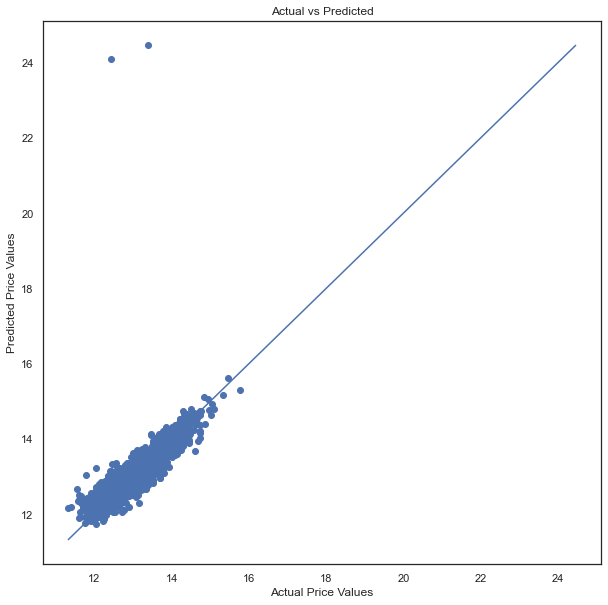

In [155]:
actual_vs_predicted(model4, pdf_test[features], y_test)

### Model 4: OLS and Assumption Testing

In [156]:
pdf_train_wconst = sm.add_constant(pdf_train[features])
model4_ols = sm.OLS(y_train,pdf_train_wconst).fit()

In [157]:
model4_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     229.2
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:30:30   Log-Likelihood:                 3885.7
No. Observations:               17276   AIC:                            -6823.
Df Residuals:                   16802   BIC:                            -3147.
Df Model:                         473                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x2 x8         -0.2163      0.110     -1.972      0.049      -0.431      -0.001
x2^2          -1.0758      0.339     -3.177      0.001      -1.739      -0.412
x2 x6         25.9959      9.545      2.724      0.006       7.287      44.705
x2           -97.6015     37.167     -2.626      0.009    -170.453     -24.750
x2 x4          2.1353      0.499      4.280      0.000       1.157       3.113
x4 x8          0.2096      0.100      2.096      0.036       0.014       0.406
x6 x8          0.6513      3.128      0.208      0.835      -5.479       6.782
x8^2           0.0858      0.024      3.539      0.000       0.038       0.133
x8            -3.2829     12.089     -0.272      0.786     -26.980      20.414
x4 x6        -21.5723      8.660     -2.491      0.013     -38.547      -4.598
x4^2          -1.0247      0.378     -2.714      0.007      -1.765      -0.285
x4            80.7298     33.761      2.391      0.017      14.554     146.906
x1 x2          0.2052      0.101      2.033      0.042       0.007       0.403
x1^2           0.0698      0.021      3.301      0.001       0.028       0.111
x1 x4         -0.2117      0.088     -2.400      0.016      -0.385      -0.039
x1 x8         -0.1227      0.036     -3.411      0.001      -0.193      -0.052
x1 x3          0.0421      0.018      2.348      0.019       0.007       0.077
x1 x9          0.0621      0.020      3.167      0.002       0.024       0.100
x0 x1         -0.0645      0.030     -2.144      0.032      -0.124      -0.006
x1 x6        -14.3478      2.582     -5.556      0.000     -19.409      -9.286
x1            55.1895      9.971      5.535      0.000      35.645      74.734
x6          8.405e+04   2246.590     37.410      0.000    7.96e+04    8.84e+04
x6^2       -1.086e+04    290.846    -37.342      0.000   -1.14e+04   -1.03e+04
x0 x2          0.0545      0.103      0.529      0.597      -0.147       0.256
x0 x4         -0.0394      0.092     -0.431      0.667      -0.219       0.140
x0 x8         -0.0131      0.039     -0.338      0.735      -0.089       0.063
x2 x9          0.0812      0.068      1.199      0.230      -0.052       0.214
x2 x3         -0.1098      0.062     -1.759      0.079      -0.232       0.013
x1 x5      -2.306e-05    5.3e-05     -0.435      0.663      -0.000    8.08e-05
x4 x9         -0.1045      0.062     -1.682      0.093      -0.226       0.017
x3 x4          0.0946      0.058      1.641      0.101      -0.018       0.208
x1 x10         0.0011      0.000      4.580      0.000       0.001       0.002
x0 x3          0.0021      0.019      0.111      0.912      -0.035       0.039
x0^2          -0.0253      0.020     -1.262      0.207      -0.065       0.014
x0 x9         -0.0431      0.021     -2.043      0.041      -0.084      -0.002
x1 x12         0.0480      0.022      2.141      0.032       0.004       0.092
x4


 Jarque-Bera ----
3823.0480309040718

 Prob ----
0.0

 Skew ----
-0.2358621770658908

 Kurtosis ----
5.255769152178995


<ipython-input-41-42a69f1a355e>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


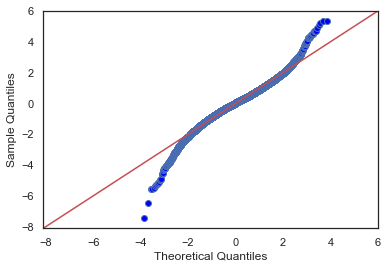

In [158]:
#test for normality
normality_test(model4_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.945862e+03
p-value                        3.238393e-169
f-value                         4.508851e+00
f p-value                      3.032949e-192

 Goldfeld-Quandt test ----
                value
F statistic  0.977262
p-value      0.850680

 Residuals plot ----


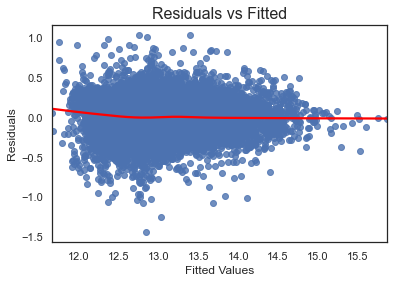

In [159]:
#test for homoscedasticity
homoscedasticity_test(model4_ols)

### Model 4: Summary

In [160]:
print('\n Model 4: Binomial Feature Engineering ----')
print(model4_summary)
print('\n Model 1: ----')
print(best_model1_summary)


 Model 4: Binomial Feature Engineering ----
The R-squared value for the train set was 0.866, and the R-squared value for the test set was 0.635. These values resulted in a differential of 0.23054. The RMSE of our model predicitons was 772139731.51

 Model 1: ----
The R-squared value for the train set was 0.889, and the R-squared value for the test set was 0.882. These values resulted in a differential of 0.00697. The RMSE of our model predicitons was 122558.91


Though Model 4 has a similar R-squared train score as that of Model 1, the Model 4 test R-squared test score was significantly lower than that of Model 1. In addition, Model 4's RMSE was significantly higher than that of Model 1. This may be due to the fact there are a few outliers in the test sample as seen in the Actual vs Predicted scatter plot above.

# Top Features in Model 1

Using the best model, which is Model 1, we found the best features by analyzing the top coefficients of the linear model.

In [161]:
features = {x[0]:abs(x[1]) for x in zip(X_test.columns,model1_ln.coef_)}
features = sorted(features.items(), key=lambda x: x[1], reverse=True)
features

[('lat', 25.745533351179503),
 ('zipcode_98039', 1.132262686716886),
 ('zipcode_98004', 0.9802743734861193),
 ('zipcode_98112', 0.9210272477794264),
 ('zipcode_98109', 0.8526699786973184),
 ('zipcode_98119', 0.8165437628190193),
 ('zipcode_98102', 0.8150224405888467),
 ('zipcode_98105', 0.7887530860443918),
 ('zipcode_98040', 0.762937167125258),
 ('zipcode_98122', 0.6874580269963169),
 ('zipcode_98107', 0.6734367858667865),
 ('zipcode_98103', 0.6580065213317456),
 ('zipcode_98199', 0.6570761414802879),
 ('zipcode_98115', 0.6435137057416902),
 ('zipcode_98033', 0.6331283044045959),
 ('grade_4', 0.6136443982725327),
 ('zipcode_98117', 0.6131825405330353),
 ('zipcode_98116', 0.6131426427941089),
 ('zipcode_98005', 0.6092281187353522),
 ('zipcode_98029', 0.5911845942822863),
 ('zipcode_98008', 0.5678828190560106),
 ('zipcode_98144', 0.5620676363842756),
 ('zipcode_98006', 0.5611237726736142),
 ('zipcode_98007', 0.5557315512432242),
 ('zipcode_98136', 0.5550874751295773),
 ('grade_5', 0.541

Upon visual inspection of the absolute value of each of the top coefficients it becomes apparent that our model predicted heavily using positional data, followed by certain grades, and sqft_living as the next non-positional continuous feature behind lat/long

## Conclusions